# Generalized Advantage Estimation

In this post we will look at how we might be able to reduce the variance of the gradient estimate given by the max
entropy policy gradient cost function that we set up last time. The first place we will start is with the baseline 
function which acts to force the expected value of each of the gradient estimates to zero. This works as a result of 
some neat algebra, the REINFORCE trick, and the fact that the expected value of the score function is zero. For 
more information on this derivation, take a look at: https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html. The code below is all the stuff from the previous post so that I can just run it here! 

In [431]:
%run running_codebase.ipynb

## Value Function Approximation (Nonlinear or Linear Regression)
The first thing that we need to do is approximate the value function which will be used in our approximation of the bsaeline. The value function will be a function of a given state at time t, and should represent the averaged value at that state. In order to perform nonlinear regression, we could create a baseline model class which consists of a nueral network with a few hidden layers, however because we are performing optimization multiple times throughout training, it will be much easier to just use linear regression.

In [ ]:
class BaselineModel(nn.Module):

    """ baseline make the score equal to zero (i.e. be equal to negative of sum of rewards) """
    """ takes in state and spits out approximation of negative of sum of rewards given your in that state"""
    """ use a linear regression becuase its fast """

    def __init__(self, input_dim, output_dim):
        super(BaselineModel, self).__init__()
        # Calling Super Class's constructor
        self.linear1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Here the forward pass is simply a linear function
        out = self.linear1(x)
        return out


## Value Function Approximation Optimization
Now we have to train this value function based upon the definition provided in https://arxiv.org/pdf/1506.02438.pdf, which is effectively the expected, discounted, cumulative reward at a given state (basically cumulative_rollout value calculated in the advantage function). The first thing we can do is just directly minimize the value function approximation and the sampled cumulative rewards at a given state from the previous iteration. To do this we wont need to define a special loss function, but can simply call MSE loss function form pytorch.

In [396]:
from torch.autograd import Variable
import numpy as np

def train_value_function(states, exp_cumu_rewards, state_size = 2, value_function = None):
    
    # initialize value function
    if value_function:
        pass
    else:
        value_function = BaselineModel(state_size, 1)
    
    # set max iterations for training
    epochs = 10**3
    
    # train to approximate average reward at state
    criterion = nn.MSELoss()
    
    # define optimizer and learning rate
    l_rate = 0.1
    optimizer = torch.optim.Adam(value_function.parameters(), lr = l_rate)
    #optimizer = torch.optim.LBFGS(value_function.parameters(), lr=l_rate)
    
    # set variables for pytorch
    states = Variable(states)
    exp_cumu_rewards = Variable(exp_cumu_rewards)
    
    # train value function model
    for epoch in range(epochs):
        
        # get predictions
        pred_cumu_rewards = torch.zeros([len(exp_cumu_rewards)])
        for sample in range(exp_cumu_rewards.size()[0]):
            pred_cumu_rewards[sample] = value_function(states[sample, :])
        
        # zero out variable gradients
        optimizer.zero_grad()
      
        # create computation graph for loss
        loss = criterion(pred_cumu_rewards, exp_cumu_rewards)

        # apply back prop
        loss.backward() 
        
        # update the parameters
        optimizer.step() 
        
#         # print info
#         if epoch%100==0:
#             print(np.floor(100*epoch/epochs), "% percent complete", ", current loss", loss, end='\r',flush=False)
    
    # return
    return value_function

## Computing the Generalized Advantage Function
Now that we have an approximation of the value function at a given state, we can create the generalized advantage estimator (GAE) which will be a function of the discount factor of the markov chain, as well as a bias variance trade off parameter defined in https://arxiv.org/pdf/1506.02438.pdf. The bais variance trade off parameter allows us to better tune the model based on how noisy the approximation of the gradient is, at the cost of a biased approximation. The calculation of this quantity is done dynamically so we dont have wasted computation, I do include an unneccsary intermediate quantity delta_t to make sure that the connection to the formula from the paper is more explicite. I also include a generate value function so that we can keep retain the current current value function as an object of the POLICY_GRADIENT_LOSS class. Additionally, due to computational, and stability constraints, I only train the value function every couple iterations to ensure that the method runs quickly and the baseline does not drastically effect the solution perceived by the agent. That is to say, if the agent gets into a poor set of trajectories, and we set the baseline at those, it will basically have very low standards andmay get stuck in a poor local minimum. If we update our loss function to include the approximation of the value function, as well as the new definition of the advantage, we have: 

In [432]:
def train_policy(epochs, grid, samples, T, discount, bv_tradeoff, alpha, sd, VF_freq):

    # initialize policy
    policy_obj = POLICY(2, 5)
    
    # set optimization info
    optimizer = torch.optim.Adam(policy_obj.parameters(), lr=1e-2)
    loss_func = POLICY_GRADIENT_LOSS(alpha, discount, bv_tradeoff, sd,  T, samples)
    
    # plotting storage (loss and cumulative reward)
    loss_per_iteration = torch.zeros((epochs))
    cr_per_iteration = torch.zeros((epochs))
    
    # train model
    for epoch in range(epochs):
        
        # set the probability of picking a random move
        randomness = (10 + epoch)/(1+epoch)**2
        
        # set policy
        policy = lambda state: policy_obj.sample_action(state, randomness)
        log_prob = lambda state, action: policy_obj.logprob_action(state, action)
        
        # get sampled trajectories
        state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
        
        # loss objective being minimized
        if epoch%VF_freq==0:
            loss, value_function = loss_func(log_prob, state_tensor, action_tensor, reward_tensor)
        else:
            loss, _ = loss_func(log_prob, state_tensor, action_tensor, reward_tensor, value_function)
            
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backprop through computation graph
        loss.backward()
        
        # step optimizer
        optimizer.step()
        
        # print loss
        print("current loss at iteration: " + str(epoch/epochs) + ", with loss: " + str(loss) + ", ends in state: " + str(state_tensor[:,-1,0]), end='\r', flush=False)
        
        # store loss
        loss_per_iteration[epoch] = loss
        cr_per_iteration[epoch] = sum(sum(reward_tensor))/samples
        
    # print a trajectory
    state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
    for time in range(50):
        print(state_tensor[:,time,0], reward_tensor[time,0], action_tensor[time,0], end='\r')

    # return policy
    return policy, loss_per_iteration, cr_per_iteration

In [433]:
class POLICY_GRADIENT_LOSS(torch.nn.Module):
    """ MAXIMUM ENTROPY POLICY GRADIENTS LOSS FUNCTION """
    def __init__(self, alpha, discount, bv_tradeoff, sd, trajectory_length, simulations):
        super(POLICY_GRADIENT_LOSS, self).__init__()
        self.sd = sd
        self.alpha = alpha
        self.discount = discount
        self.trajectory_length = trajectory_length
        self.simulations = simulations
        self.bv_tradeoff = bv_tradeoff
        self.value_function = None
        
    def generate_value_function(self, sampled_values, sampled_states):
        """ TRAIN VALUE FUNCTION """
        state_size = len(sampled_states[0,:])
        if self.value_function == None:
            self.value_function = train_value_function(sampled_states, sampled_values, state_size)
            return self.value_function
        else:
            self.value_function = train_value_function(sampled_states, sampled_values, state_size, self.value_function)
            return self.value_function
        
    def Advantage_estimator(self, logliklihood_tensor, trajectories_state_tensor, \
                            trajectories_action_tensor, trajectories_reward_tensor, \
                            value_function):
        """ COMPUTES ROLL OUT WITH MAX ENT REGULARIZATION """
        # initialize cumulative running average for states ahead
        advantage = torch.zeros([self.trajectory_length, self.simulations])
        delta_t = torch.zeros([self.trajectory_length, self.simulations])
        # calculate last delta term
        delta_t[self.trajectory_length-1,:] = trajectories_reward_tensor[self.trajectory_length-1,:] \
                                                         + self.alpha*logliklihood_tensor[self.trajectory_length-1,:]
        # calculate last advantage value
        advantage[self.trajectory_length-1,:] = delta_t[self.trajectory_length-1,:]
        # compute other delta values
        for time in reversed(range(0, self.trajectory_length-1)):
            for simulation in range(self.simulations):
                delta_t[time,simulation] = trajectories_reward_tensor[time, simulation] + self.alpha * logliklihood_tensor[time,simulation] \
                                    - self.value_function(trajectories_state_tensor[:,time,simulation]) \
                                    + self.discount * self.value_function(trajectories_state_tensor[:,time+1,simulation]) 
                advantage[time,simulation] = delta_t[time,simulation] + self.discount * self.bv_tradeoff * advantage[time+1,simulation]
        
        # detach cumulative reward from computation graph
        advantage = advantage.detach()
        
        # return everything
        return advantage

    def forward(self, model_liklihood, trajectories_state_tensor, trajectories_action_tensor, \
                trajectories_reward_tensor, value_function = None):
        """ CALCULATE LOG LIKLIHOOD OF TRAJECTORIES """
        # initialize tensor for log liklihood stuff
        logliklihood_tensor = torch.zeros([self.trajectory_length, self.simulations])
        # initialize tensors for training a value function
        cumulative_reward = torch.zeros([self.trajectory_length+1, self.simulations])
        sampled_values = torch.zeros([self.trajectory_length * self.simulations])
        sampled_states = torch.zeros([len(trajectories_state_tensor[:,0,0]), self.trajectory_length * self.simulations])
        # append extra value to account for the end of the trajectory
        cumulative_reward[self.trajectory_length,:] = trajectories_reward_tensor[self.trajectory_length-1,:] \
                                                         + self.alpha*logliklihood_tensor[self.trajectory_length-1,:]
        # generate tensor for log liklihood and empirical value function samples 
        for time in reversed(range(self.trajectory_length)):
            for simulation in range(self.simulations):
                # logliklihood [simulation #, value, time step]
                logliklihood_tensor[time,simulation] = model_liklihood(trajectories_state_tensor[:,time,simulation],\
                                                                       trajectories_action_tensor[time,simulation])
            # cumulative reward
            cumulative_reward[time,:] = trajectories_reward_tensor[time, :] + self.alpha * logliklihood_tensor[time,:] \
                                        + cumulative_reward[time+1,:]
            # value function info
            sampled_values[time*simulations:(time+1)*simulations] = cumulative_reward[time,:]
            sampled_states[:,time*simulations:(time+1)*simulations] = trajectories_state_tensor[:,time,:]
        
        """ TRAIN VALUE FUNCTION """
        if value_function == None:
            value_function = self.generate_value_function(sampled_values, sampled_states.transpose(0, 1))
        
        """ CALCULATE ADVANTAGE REGULARIZED BY ENTROPY """
        A_hat = self.Advantage_estimator(logliklihood_tensor, trajectories_state_tensor, trajectories_action_tensor, \
                                         trajectories_reward_tensor, value_function)
        
        """ CALCULATE POLICY GRADIENT OBJECTIVE """
        # initialize expectation tensor
        expectation = 0
        
        # calculate instance of expectation for timestep then calc sample mean
        for time in range(self.trajectory_length):
            expectation += torch.dot(A_hat[time,:], logliklihood_tensor[time,:])/self.simulations    
        
        # sum accross time
        expectation = -1 * torch.sum(expectation)/self.trajectory_length

        """ RETURN """
        return expectation, value_function
        

# Now all we have to do is run it!
Below I have set the grid that we will be using, as well as the start state and the number of iterations.  

In [420]:
pre_determined_grid = [[-1,   -1,  -1,   -10,   -1, 10**5],
                       [-100, -1,  -10,  -1,    -10,  -10],
                       [-100, -1,  -100, -10,   -10,  -10],
                       [-1,   -1,  -100, -100,  -10,   -1],
                       [-10,  -1,  -100, -100,  -100,  -1],
                       [-1,   -1,  -100, -100,  -100,  -100]]

# hyper parameters
iterations = 500
Time = 50
simulations = 10
discount = 0.99
bv_tradeoff = 0.99
VF_freq = 100

#initializations
start_state = [5,0]
policy_obj = POLICY(2, 5)
policy = lambda state: policy_obj.sample(state)
grid = GRID_WORLD(pre_determined_grid, start_state)
policy, loss_per_iteration, cr_per_iteration = train_policy(iterations, grid, simulations, Time, discount, bv_tradeoff, 1, 1)

## Now lets plot everything 

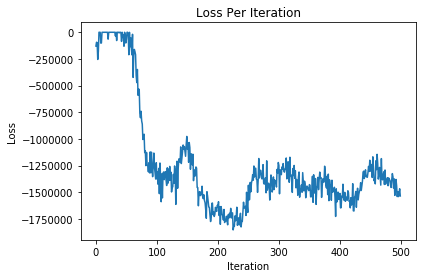

In [421]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(iterations)], -1*loss_per_iteration.detach().numpy())
plt.title('Loss Per Iteration')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

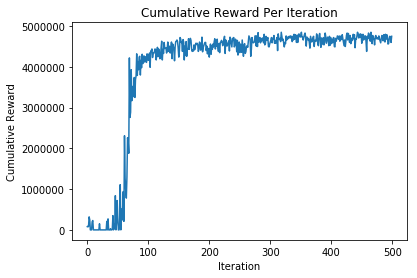

In [422]:
plt.plot([i for i in range(iterations)], cr_per_iteration.numpy())
plt.title('Cumulative Reward Per Iteration')
plt.ylabel('Cumulative Reward')
plt.xlabel('Iteration')
plt.show()

## It looks like everything has converged, but lets look a trajectory to see if we are actually close

In [423]:
T = 50
samples = 1
state_tensor, action_tensor, reward_tensor = grid.simulate_trajectory(T, samples, policy)
for time in range(25):
    print(state_tensor[:,time,0], reward_tensor[time,0], action_tensor[time,0])

tensor([5., 0.]) tensor(-1.) tensor(4.)
tensor([5., 0.]) tensor(-1.) tensor(1.)
tensor([4., 0.]) tensor(-10.) tensor(1.)
tensor([3., 0.]) tensor(-1.) tensor(0.)
tensor([3., 0.]) tensor(-1.) tensor(3.)
tensor([3., 1.]) tensor(-1.) tensor(1.)
tensor([2., 1.]) tensor(-1.) tensor(1.)
tensor([1., 1.]) tensor(-1.) tensor(0.)
tensor([1., 1.]) tensor(-1.) tensor(1.)
tensor([0., 1.]) tensor(-1.) tensor(3.)
tensor([0., 2.]) tensor(-1.) tensor(2.)
tensor([1., 2.]) tensor(-10.) tensor(3.)
tensor([1., 3.]) tensor(-1.) tensor(3.)
tensor([1., 4.]) tensor(-10.) tensor(3.)
tensor([1., 5.]) tensor(-10.) tensor(3.)
tensor([1., 5.]) tensor(-10.) tensor(1.)
tensor([0., 5.]) tensor(100000.) tensor(1.)
tensor([0., 5.]) tensor(100000.) tensor(1.)
tensor([0., 5.]) tensor(100000.) tensor(3.)
tensor([0., 5.]) tensor(100000.) tensor(3.)
tensor([0., 5.]) tensor(100000.) tensor(3.)
tensor([0., 5.]) tensor(100000.) tensor(1.)
tensor([0., 5.]) tensor(100000.) tensor(3.)
tensor([0., 5.]) tensor(100000.) tensor(3.)
ten

## We can also look at what actions are sampled at all positions to see if they seem reasonable

In [428]:
for x in range(len(pre_determined_grid[0])):
    row = []
    for y in range(len(pre_determined_grid)):
        row.append(int(policy([x, y])))
    print(row)

[1, 3, 1, 3, 1, 1]
[2, 3, 2, 3, 1, 3]
[1, 1, 1, 0, 1, 1]
[0, 3, 1, 1, 3, 3]
[1, 1, 1, 1, 3, 1]
[1, 1, 3, 1, 1, 1]


## Thats it for the GAE (for now)!
Now we have implemented a simple version of the value function defined in the generalized advantage estimation, albeit somewhat niavely. There does not really seem to be that much advantage in using this extra variance reduction technique, as it drastically slows down training time due at each iteration. The loss function over time did look substantially smoother throughout the course of training, and the solution found was definitly more optimal then the one found in the original codebase, however the training time was still a limitation. Whats more, I was forced to include a somewhat hacky work around to the GAE training which when applied at every iteration actually led to extremely poor results. This might be remedied by using a decaying exponential average, or using trust region updates, but the efficieny issue still remains. Next time we will impliment a trust region update for the method, as well as conjugate gradient update that should substantially improve training time for the value function iterations.